<a href="https://colab.research.google.com/github/bartek-wojcik/usa_election_2020_sentiment_analysis/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#### Colab Setup

In [ ]:
# Install java
import os
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark


openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)
     |████████████████████████████████| 204.2MB 70kB/s 
     |████████████████████████████████| 204kB 45.7MB/s 


#### Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1. Load SparkSession

In [ ]:
from pyspark.sql import SparkSession

session = SparkSession.builder \
    .appName("Spark")\
    .master("local[4]")\
    .config("spark.driver.memory","12G")\
    .config("spark.executor.memory", "12G")\
    .config("spark.driver.maxResultSize", "0") \
    .getOrCreate()

print("Apache Spark version: ", session.version)

Apache Spark version:  3.0.1


#### 3. Load data

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

def read_csv(name):
    return session.read\
        .option("sep", ",")\
        .option("multiLine", "true")\
        .option("inferSchema", "true")\
        .option("header", "true")\
        .option("quote", '"')\
        .option("escape", '"')\
        .option("delimiter", ",")\
        .csv(f'file:///content/drive/MyDrive/Datasets/{name}.csv')


trump_ml_df = read_csv('donaldtrump_sentiment_ml').cache()
biden_ml_df = read_csv('joebiden_sentiment_ml').cache()
trump_dl_df = read_csv('donaldtrump_sentiment_dl').cache()
biden_dl_df = read_csv('joebiden_sentiment_dl').cache()

In [ ]:
trump_dl_df.show()

+-------------------+--------------------+--------------------+-----+-------------+-------------------+-------------------+--------------------+--------------------+------------------+-------------------+-----------------+--------------------+-------------+--------------------+----------+--------------------+-------------+
|         created_at|            tweet_id|                text|likes|retweet_count|             source|     user_join_date|user_followers_count|       user_location|               lat|               long|             city|             country|    continent|               state|state_code|        collected_at|sentiment_res|
+-------------------+--------------------+--------------------+-----+-------------+-------------------+-------------------+--------------------+--------------------+------------------+-------------------+-----------------+--------------------+-------------+--------------------+----------+--------------------+-------------+
|2020-10-15 00:00:01|1.31

#### 4. Analyze data


In [ ]:
def count_sentiment(df):
    data = df.filter('sentiment_res is not null')\
        .groupBy(['sentiment_res'])\
        .count()
    data.show()
    return data.toPandas()


In [ ]:
def group_by_dates(df):
    data = df.withColumn("date", to_date(col("created_at"),"yyyy-MM-dd HH:mm:ss"))\
        .filter('date is not null and sentiment_res is not null')\
        .select(['sentiment_res', 'date'])\
        .groupBy(['date', 'sentiment_res'])\
        .count()\
        .orderBy(['date', 'sentiment_res'])
    data.show()
    return data.toPandas()


In [ ]:
trump_dl_df.select(['text', 'sentiment_res']).show(20, False)
trump_ml_df.select(['text', 'sentiment_res']).show(20, False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|text                                                                                                                                                                                                                                                |sentiment_res|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|Elecciones2020  En Florida JoeBiden dice que DonaldTrump solo se preocupa por l mismo El demcrata fue anfitrin de encuentros de electores en PembrokePines y Miramar Clic AQU ElSolLatino yobrilloconelsol              

In [ ]:
count_sentiment(trump_dl_df)
trump_sentiment = count_sentiment(trump_ml_df)

+-------------+------+
|sentiment_res| count|
+-------------+------+
|     positive|575836|
|      neutral| 14907|
|     negative|380176|
+-------------+------+

+-------------+------+
|sentiment_res| count|
+-------------+------+
|     positive|349722|
|      neutral|152218|
|     negative|468970|
+-------------+------+



In [ ]:
count_sentiment(biden_dl_df)
biden_sentiment = count_sentiment(biden_ml_df)

+-------------+------+
|sentiment_res| count|
+-------------+------+
|     positive|571773|
|      neutral|  9578|
|     negative|195535|
+-------------+------+

+-------------+------+
|sentiment_res| count|
+-------------+------+
|     positive|291980|
|      neutral|134482|
|     negative|350409|
+-------------+------+



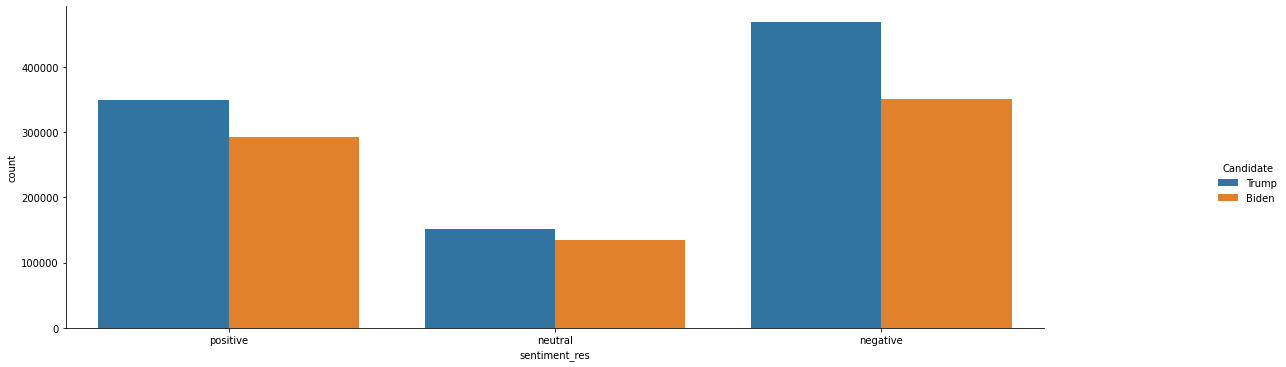

In [ ]:
import seaborn as sns
import pandas as pd
df = pd.concat([trump_sentiment, biden_sentiment], axis=0, ignore_index=False)
df['Candidate'] = (len(trump_sentiment)*('Trump',) + len(biden_sentiment)*('Biden',))
df.reset_index(inplace=True)
plot = sns.catplot(x='sentiment_res', y='count', hue='Candidate', kind='bar', data=df)
plot.fig.set_figwidth(20)

In [ ]:
totals_trump = len(trump_ml_df.toPandas().index)

totals_trump

970919

In [ ]:
totals_biden = len(biden_ml_df.toPandas().index)

totals_biden

776886

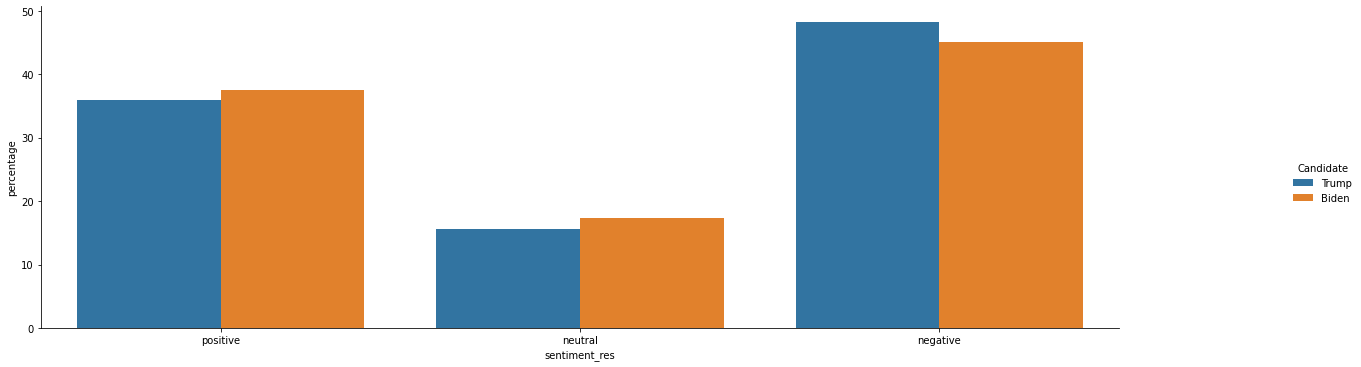

In [ ]:
import numpy as np

df['percentage'] = np.where(df['Candidate'] == 'Trump', df['count'] / totals_trump * 100, df['count'] / totals_biden * 100)
plot = sns.catplot(x='sentiment_res', y='percentage', hue='Candidate', kind='bar', data=df)
plot.fig.set_figwidth(20)

In [ ]:
from pyspark.sql import functions as F

def count_field(df, field):
    data = df.select(F.sum(field))
    data.show()
    return data.collect()[0][0]

+----------+
|sum(likes)|
+----------+
| 7894066.0|
+----------+

+------------------+
|sum(retweet_count)|
+------------------+
|         1655801.0|
+------------------+

+----------+
|sum(likes)|
+----------+
| 7259572.0|
+----------+

+------------------+
|sum(retweet_count)|
+------------------+
|         1649106.0|
+------------------+

{'Candidate': ['Trump', 'Trump', 'Biden', 'Biden'], 'Type': ['Likes', 'Retweets', 'Likes', 'Retweets'], 'Value': [7259572.0, 1649106.0, 7894066.0, 1655801.0]}


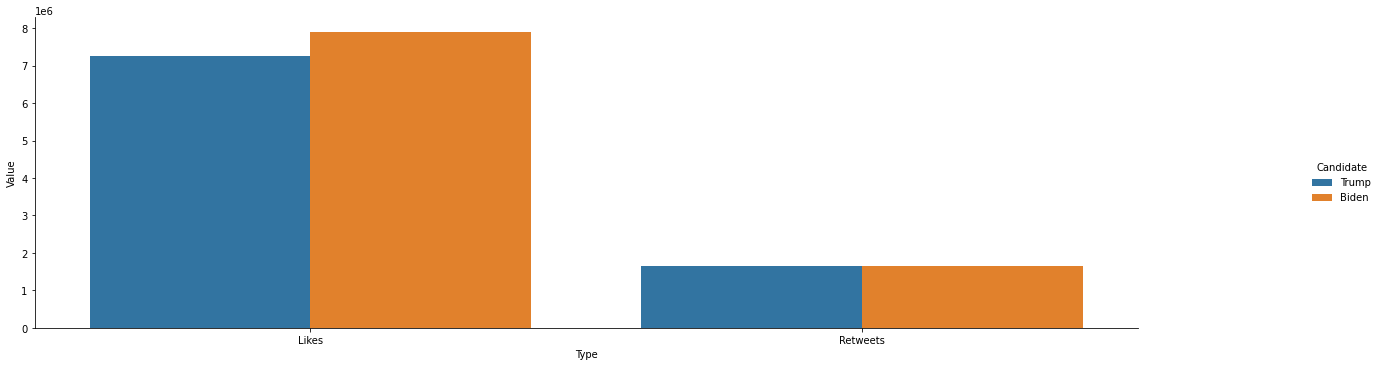

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

biden_likes = count_field(biden_ml_df, 'likes')
biden_retweeets = count_field(biden_ml_df, 'retweet_count')

trump_likes = count_field(trump_ml_df, 'likes')
trump_retweeets = count_field(trump_ml_df, 'retweet_count')

data = {
    'Candidate': ['Trump', 'Trump', 'Biden', 'Biden'],
    'Type': ['Likes', 'Retweets'] * 2,
    'Value': [trump_likes, trump_retweeets, biden_likes, biden_retweeets]
}

print(data)

df = pd.DataFrame(data=data)
plot = sns.catplot(x='Type', y='Value', hue='Candidate', kind='bar', data=df)
plot.fig.set_figwidth(20)

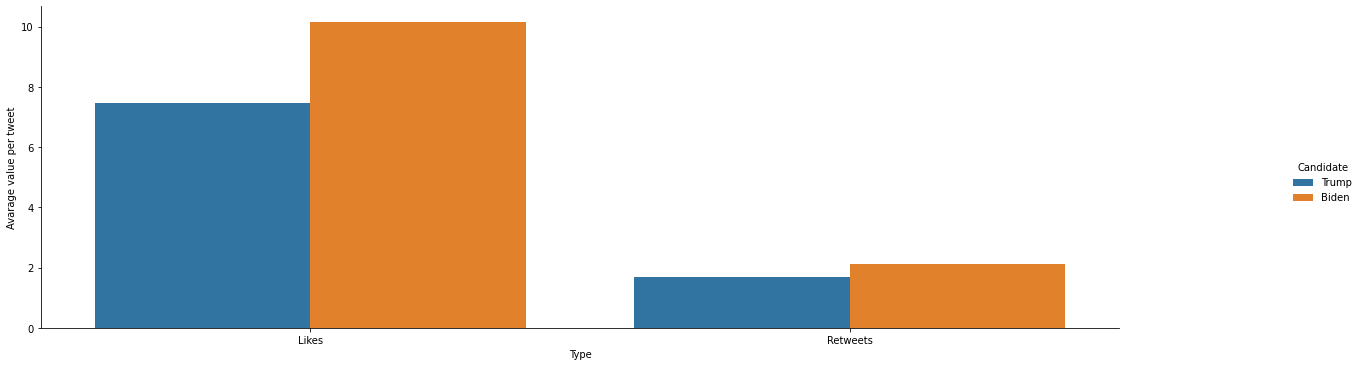

In [ ]:
df['Avarage value per tweet'] = np.where(df['Candidate'] == 'Trump', df['Value'] / totals_trump, df['Value'] / totals_biden)
plot = sns.catplot(x='Type', y='Avarage value per tweet', hue='Candidate', kind='bar', data=df)
plot.fig.set_figwidth(20)

In [ ]:
def count_users_per_day(df, start_date='2006-03-21'):
    data = df.select(from_unixtime(unix_timestamp(df['user_join_date'], 'yyyy-MM-dd HH:mm:ss')).alias('date').cast("date")).filter(f"date > date'{start_date}'")
    return data.toPandas().value_counts('date').sort_index()


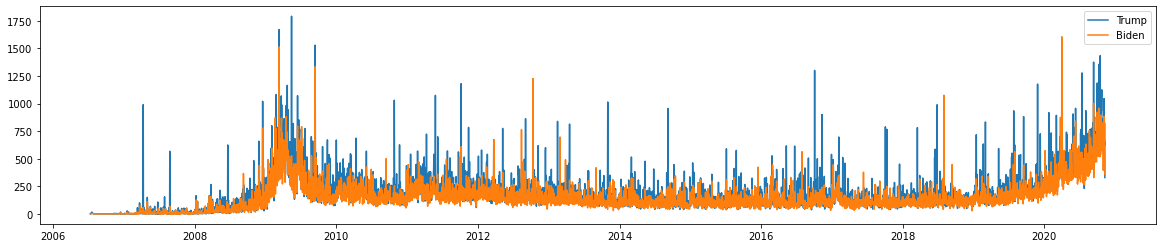

In [ ]:
import matplotlib.pyplot as plt
users_per_day_biden = count_users_per_day(biden_ml_df)
users_per_day_trump = count_users_per_day(trump_ml_df)
fig, ax = plt.subplots()
fig.set_figwidth(20)
plt.plot(users_per_day_trump.index, users_per_day_trump.values, label='Trump')
plt.plot(users_per_day_biden.index, users_per_day_biden.values, label='Biden')
plt.legend()
plt.show()

In [ ]:
def count_sentiment_per_day(df):
    data = df.select(from_unixtime(unix_timestamp(df['created_at'], 'yyyy-MM-dd HH:mm:ss')).alias('date').cast("date"), 'sentiment_res').groupBy('date', 'sentiment_res').count()
    return data.toPandas()

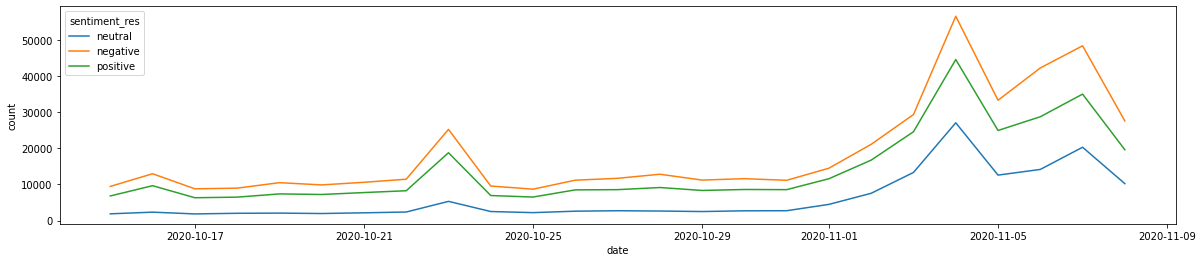

In [ ]:
trump_sentiment_per_day = count_sentiment_per_day(trump_ml_df)
plt.figure(figsize=(20,4))
plot = sns.lineplot(data=trump_sentiment_per_day, x='date', y='count', hue='sentiment_res')

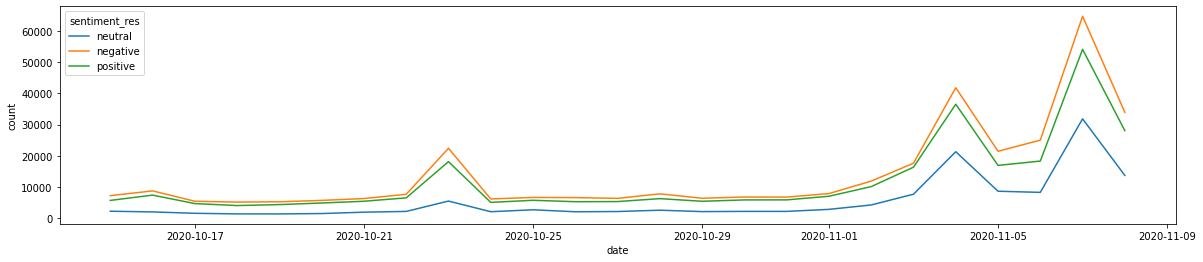

In [ ]:
biden_sentiment_per_day = count_sentiment_per_day(biden_ml_df)
plt.figure(figsize=(20,4))
plot = sns.lineplot(data=biden_sentiment_per_day, x='date', y='count', hue='sentiment_res')

In [ ]:
!pip install geopandas --upgrade
!pip install shapely
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

     |████████████████████████████████| 972kB 4.1MB/s 
     |████████████████████████████████| 6.5MB 12.3MB/s 
     |████████████████████████████████| 14.8MB 257kB/s 


In [ ]:
def plot_map(df):
    df = df.select(['long', 'lat']).toPandas()
    geometry = gpd.points_from_xy(df['long'], df['lat'])
    gdf = gpd.GeoDataFrame(df, geometry=geometry)   

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(figsize=(12, 8)), marker='.', color='orange', markersize=0.5)

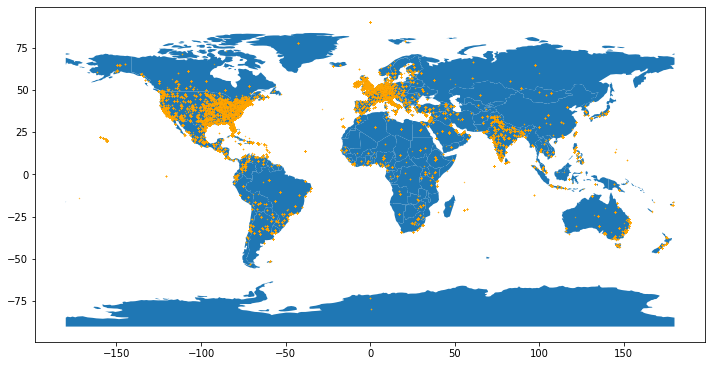

In [ ]:
plot_map(biden_ml_df)

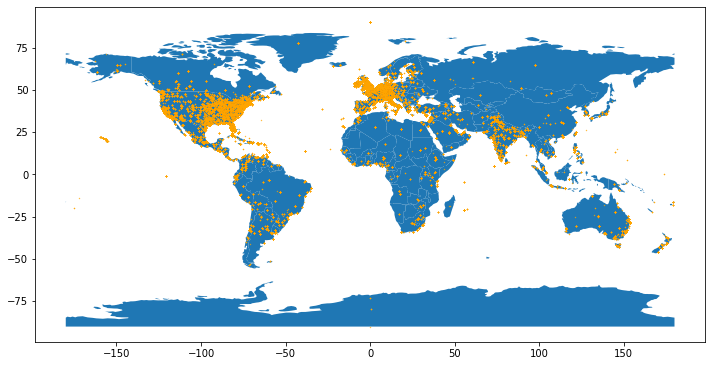

In [ ]:
plot_map(trump_ml_df)

In [ ]:
colordict = {
    'neutral': 'Oranges',
    'negative': 'autumn', 
    'positive': 'Wistia', 
}

from math import floor
from pyspark.sql import Row

step = 1.2
to_bin = lambda x: floor(x / step) * step

def format_record(r):
    return Row(
        long = to_bin(r['long']),
        lat = to_bin(r['lat']),
        sentiment_res = r['sentiment_res']
    )

def plot_map_sentiment(df, sent):
    data = df.select(['long', 'lat', 'sentiment_res'])\
             .filter(f"sentiment_res == '{sent}' and long is not null")\
             .rdd\
             .map(format_record)

    data = data.toDF().groupBy(['long', 'lat']).agg(F.count('sentiment_res')).alias('count').toPandas()
    geometry = gpd.points_from_xy(data['long'], data['lat'])
    gdf = gpd.GeoDataFrame(data, geometry=geometry)   
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(figsize=(18, 8)), marker='.', column=data['count(sentiment_res)'], markersize=15, cmap=colordict[sent])


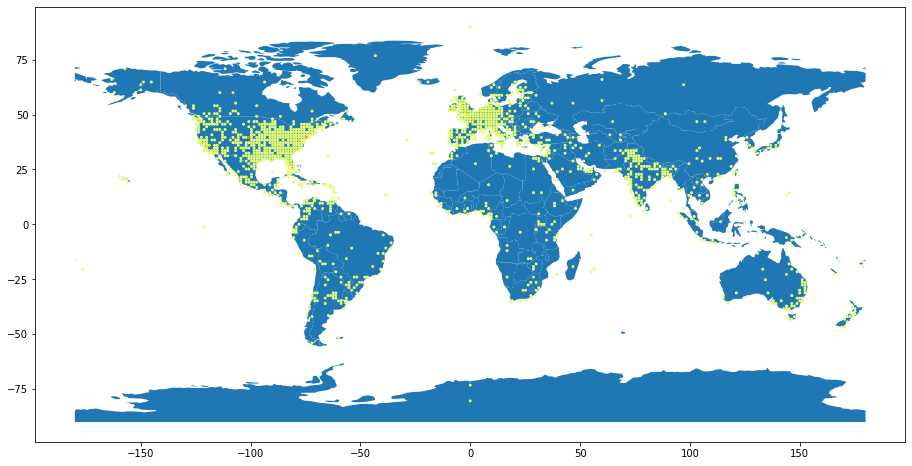

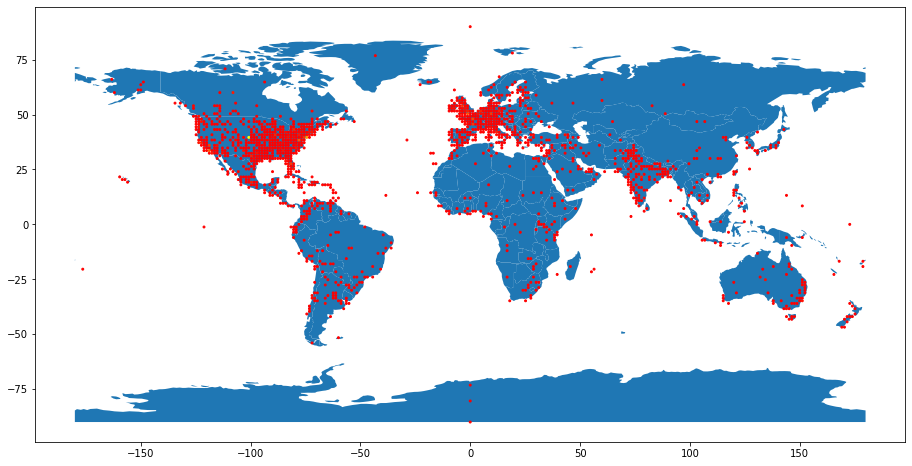

In [ ]:
plot_map_sentiment(trump_ml_df, 'positive')
plot_map_sentiment(trump_ml_df, 'negative')

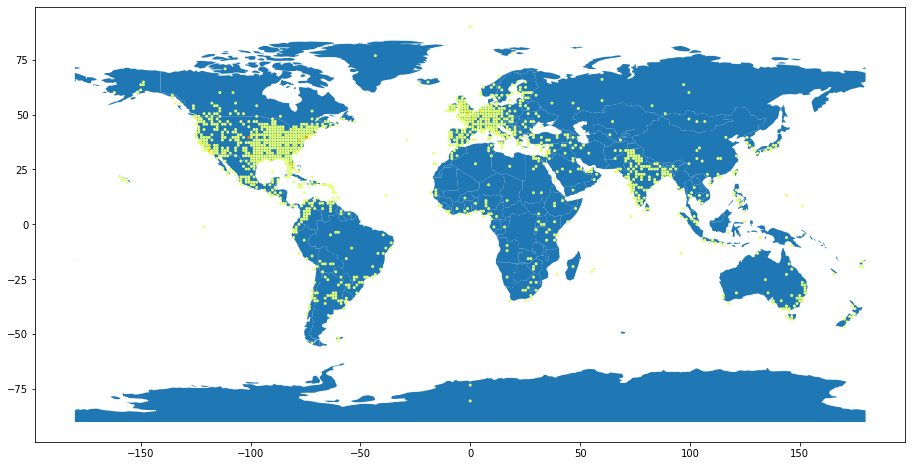

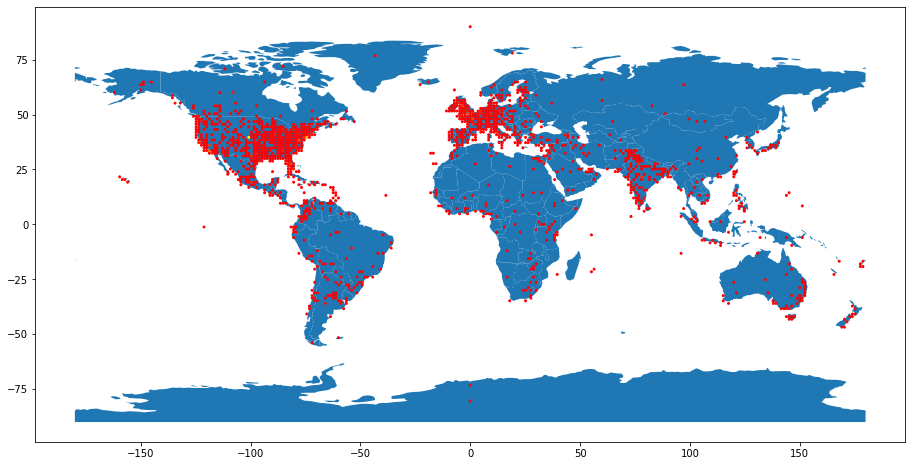

In [ ]:
plot_map_sentiment(biden_ml_df, 'positive')
plot_map_sentiment(biden_ml_df, 'negative')

In [ ]:
def count_sources(df):
    data = df.select(['sentiment_res', 'source']).groupBy(['sentiment_res', 'source']).agg(F.count('source')).orderBy('count(source)', ascending=False)
    data.show()
    plot = sns.catplot(x='source', y='count(source)', hue='sentiment_res', kind='bar', data=data.toPandas().head(20), palette=["red", "green", "blue"])
    plot.fig.set_figwidth(20)
    return data


+-------------+-------------------+-------------+
|sentiment_res|             source|count(source)|
+-------------+-------------------+-------------+
|     negative|    Twitter Web App|       113249|
|     negative| Twitter for iPhone|       110980|
|     positive| Twitter for iPhone|        93247|
|     positive|    Twitter Web App|        93020|
|     negative|Twitter for Android|        92599|
|     positive|Twitter for Android|        77846|
|      neutral|Twitter for Android|        48488|
|      neutral| Twitter for iPhone|        40579|
|      neutral|    Twitter Web App|        34037|
|     negative|   Twitter for iPad|        11712|
|     positive|   Twitter for iPad|         9833|
|     negative|          TweetDeck|         5975|
|     positive|          TweetDeck|         4685|
|      neutral|   Twitter for iPad|         4484|
|     negative|          Instagram|         2551|
|     positive|          Instagram|         2241|
|     negative|     Hootsuite Inc.|         2008|


DataFrame[sentiment_res: string, source: string, count(source): bigint]

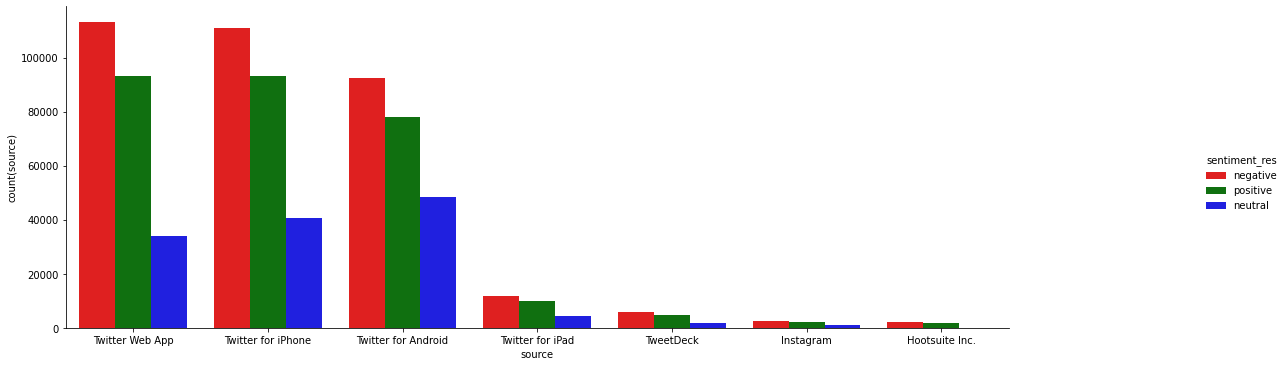

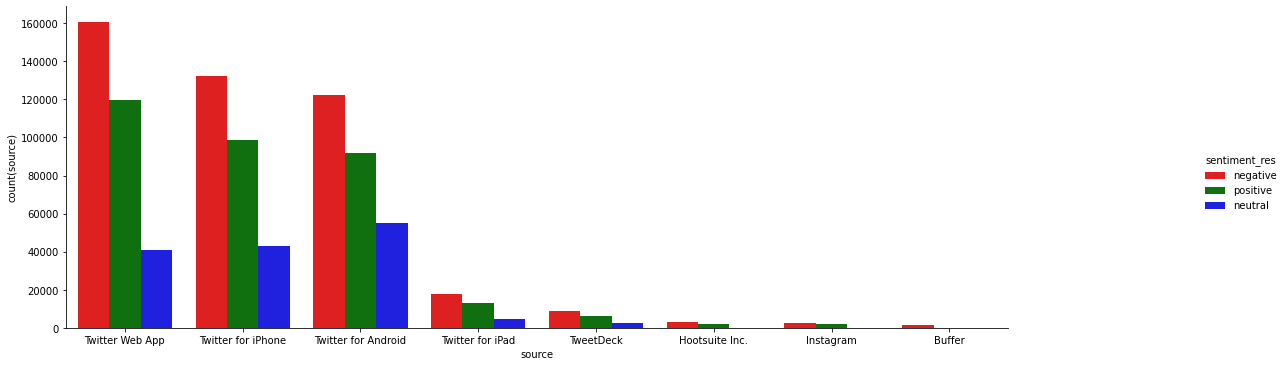

In [ ]:
count_sources(biden_ml_df)
count_sources(trump_ml_df)

In [ ]:
!rm -rf data
!unzip -o -d data /content/drive/MyDrive/Datasets/States_shapefile-shp.zip


Archive:  /content/drive/MyDrive/Datasets/States_shapefile-shp.zip
  inflating: data/States_shapefile.dbf  
  inflating: data/States_shapefile.shp  
  inflating: data/States_shapefile.shx  
  inflating: data/States_shapefile.prj  
 extracting: data/States_shapefile.cpg  


In [ ]:
def find_state_value(df, code):
    return df.loc[df['state_code'] == code]['count(sentiment_res)'].values[0]

def generate_state_map(df, type):
    states = gpd.read_file('data/States_shapefile.shp')
    data = df.select(['sentiment_res', 'state_code'])\
             .filter(f"state_code is not null and sentiment_res = '{type}'")\
             .groupBy('state_code')\
             .agg(F.count('sentiment_res'))\
             .toPandas()
    print(data)
    states = states.to_crs("EPSG:3395")
    states = states[states['State_Code'].isin(data.state_code)]
    values = states['State_Code'].apply(lambda code: find_state_value(data, code))
    states = states.assign(sentiment=values)
    states.plot(figsize=(12, 12), column='sentiment', legend=True)
    plt.show()
    return states


    state_code  count(sentiment_res)
0            K                     3
1          MOR                    14
2          NCD                    12
3           SC                   480
4           AZ                  1311
..         ...                   ...
267        NSW                   652
268          H                     1
269        LIG                    43
270         HI                   248
271         ST                    20

[272 rows x 2 columns]


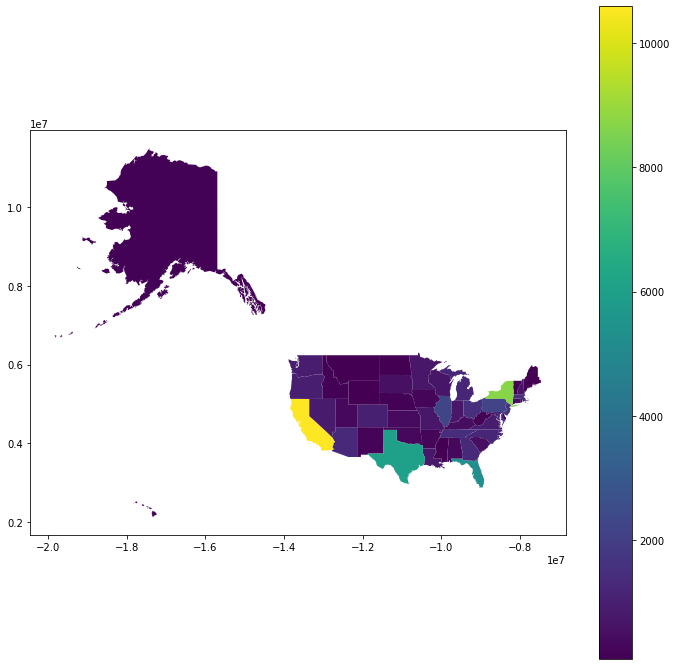

    state_code  count(sentiment_res)
0            K                     3
1          MOR                    29
2          NCD                    13
3           SC                   585
4           AZ                  1613
..         ...                   ...
277        NSW                   758
278          H                     1
279        LIG                    46
280         HI                   300
281         ST                    16

[282 rows x 2 columns]


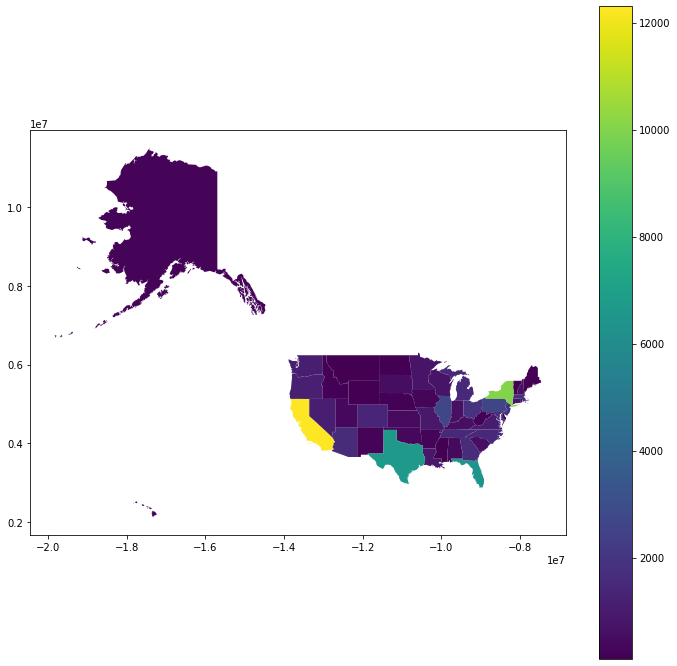

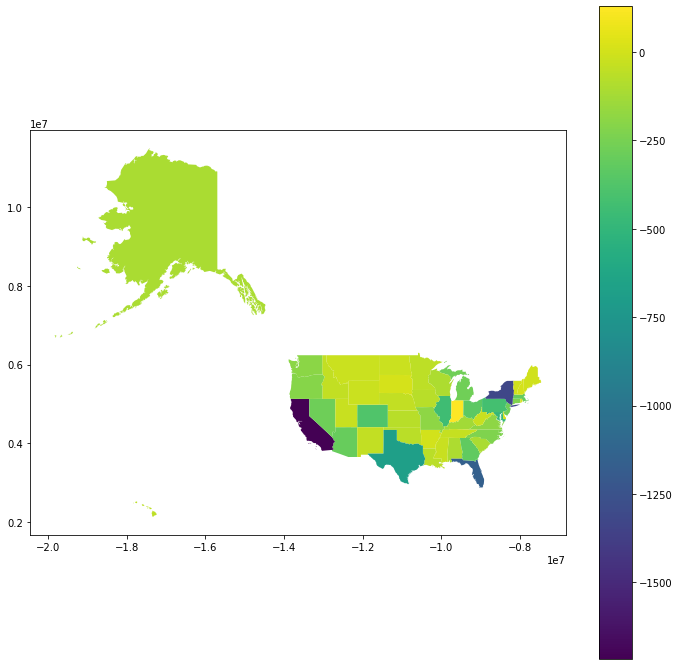

In [ ]:
def generate_difference_map(df):
     positive = generate_state_map(df, 'positive')
     negative = generate_state_map(df, 'negative')
     states = positive.assign(difference=positive.sentiment - negative.sentiment)
     states.plot(figsize=(12, 12), column='difference', legend=True)

generate_difference_map(biden_ml_df)

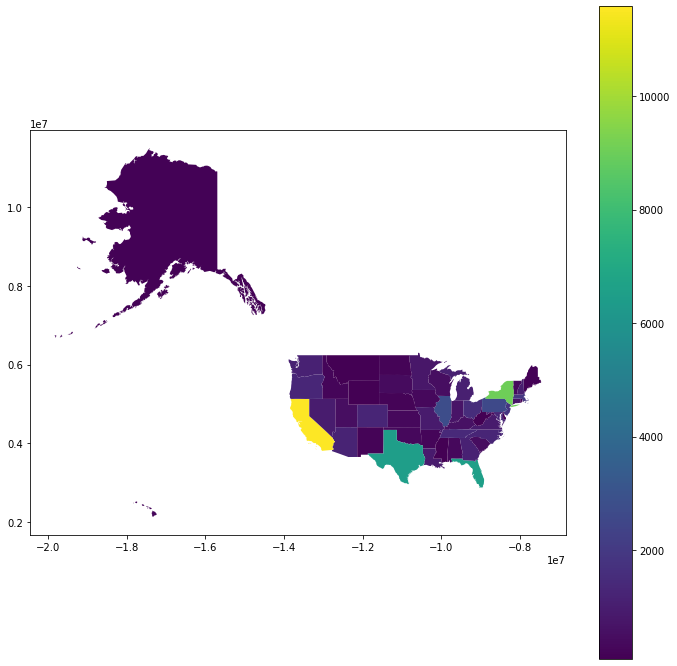

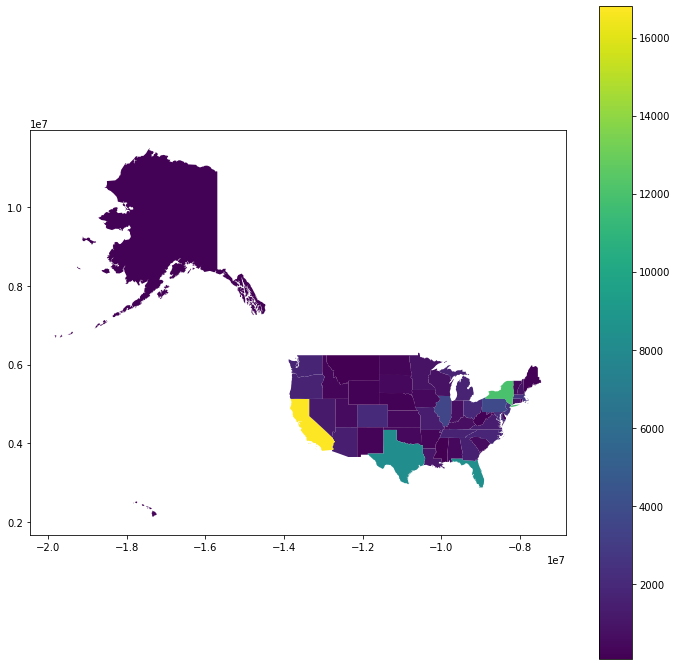

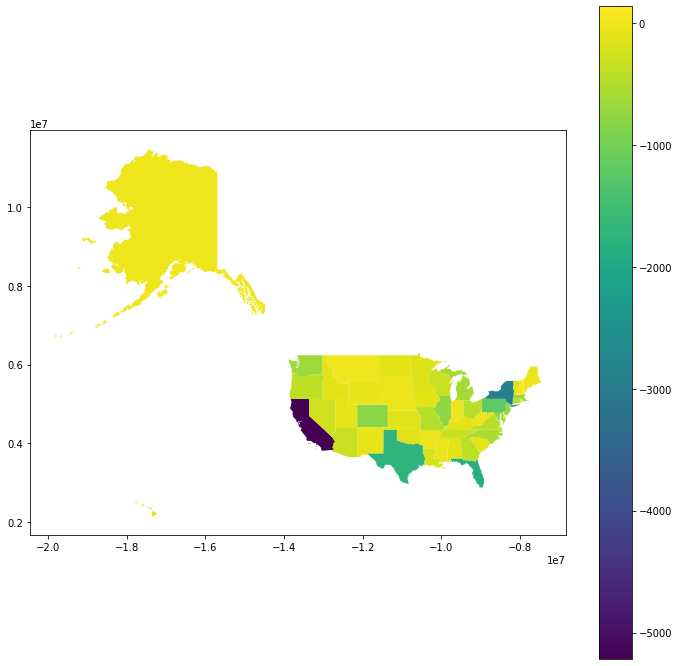

In [ ]:
generate_difference_map(trump_ml_df)